## Download the dataset from zenodo

In [ ]:
import requests
from tqdm import tqdm

url = "https://zenodo.org/record/16153275/files/shd_norm.mat"
filename = "shd_norm.mat"
# filename = "ssc_norm.h5"

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024

with open(filename, "wb") as file, tqdm(
    desc=f"Downloading {filename}",
    total=total_size,
    unit='B',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(block_size):
        file.write(data)
        bar.update(len(data))

print(f" Done: {filename}")

 Done: shd_norm.mat


## Setup and Imports

Import necessary libraries for SLAYER SNN training with SHD-Norm dataset.

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import sys
import os

# Add slayerSNN to path
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")
import slayerSNN as snn

# Constants
ms = 1e-3  # use this constant so you can write e.g. 1*ms for a time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Loading and Preprocessing

Load the SHD-Norm dataset and implement preprocessing functions including partial randomization for robustness testing.

In [3]:
# === Load and prepare dataset ===
print("Loading SHD-Norm dataset...")
data = io.loadmat("shd_norm.mat")
X = data["X"]  # shape: (samples, neurons, time_steps)
Y = data["Y"].ravel()

print(f"Original dataset shape: X={X.shape}, Y={Y.shape}")
print(f"Number of classes: {len(np.unique(Y))}")
print(f"Class distribution: {np.bincount(Y)}")

# Pad time dimension if needed (target 200 time steps)
num_neurons, T_ori = X.shape[1], X.shape[2]
num_classes = len(np.unique(Y))
T_target = 200

if T_ori < T_target:
    print(f"Padding time dimension from {T_ori} to {T_target}")
    padded = np.zeros((X.shape[0], num_neurons, T_target), dtype=X.dtype)
    padded[:, :, :T_ori] = X
    X = padded
    T = T_target
else:
    T = T_ori

print(f"Final dataset shape: X={X.shape}")

# === Partial randomization function ===
def partial_randomize_spike_train(spike_train, f=0.0, max_attempts=50):
    """
    Partially randomize spike timings in a spike train with probability f.
    
    Args:
        spike_train: numpy array of shape (neurons, time_steps)
        f: randomization probability (0.0 = no randomization, 1.0 = full randomization)
        max_attempts: maximum attempts to find empty time slot for relocated spike
    
    Returns:
        new_train: randomized spike train
    """
    if f <= 0:
        return spike_train
    
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)
    
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            if np.random.rand() < f:
                # Remove spike from original position
                new_train[neuron_idx, old_time] = 0
                
                # Try to place it in a new random position
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T)
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True
    
    return new_train

# === Dataset class ===
class SpikeTensorDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

Loading SHD-Norm dataset...
Original dataset shape: X=(5460, 224, 100), Y=(5460,)
Number of classes: 20
Class distribution: [273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273
 273 273]
Padding time dimension from 100 to 200
Final dataset shape: X=(5460, 224, 200)
Final dataset shape: X=(5460, 224, 200)


In [4]:
# === Data splitting configuration ===
training_range   = (0.0, 0.6)   # 60% for training
validation_range = (0.6, 0.75)  # 15% for validation  
testing_range    = (0.75, 0.9)  # 15% for testing

def preprocess_dataset(X, Y, f=0.0, batch_size=128, seed=42):
    """
    Preprocess dataset with partial randomization and create data loaders.
    
    Args:
        X: input spike data
        Y: labels
        f: randomization factor
        batch_size: batch size for data loaders
        seed: random seed
    
    Returns:
        train_loader, val_loader, test_loader
    """
    np.random.seed(seed)
    N = len(Y)
    
    # Define data splits
    train_start, train_end = training_range
    val_start, val_end = validation_range
    test_start, test_end = testing_range

    train_indices = np.arange(int(N * train_start), int(N * train_end))
    val_indices   = np.arange(int(N * val_start), int(N * val_end))
    test_indices  = np.arange(int(N * test_start), int(N * test_end))

    # Shuffle training indices
    np.random.shuffle(train_indices)

    # Apply partial randomization to each split
    print(f"Applying partial randomization with f={f} to all splits...")
    X_train_proc = np.array([partial_randomize_spike_train(X[i], f) for i in train_indices])
    X_val_proc   = np.array([partial_randomize_spike_train(X[i], f) for i in val_indices])
    X_test_proc  = np.array([partial_randomize_spike_train(X[i], f) for i in test_indices])

    Y_train = Y[train_indices]
    Y_val   = Y[val_indices]
    Y_test  = Y[test_indices]
    
    print(f"Dataset splits: Train={len(Y_train)}, Val={len(Y_val)}, Test={len(Y_test)}")

    # Create datasets and loaders
    train_ds = SpikeTensorDataset(X_train_proc, Y_train)
    val_ds   = SpikeTensorDataset(X_val_proc, Y_val)
    test_ds  = SpikeTensorDataset(X_test_proc, Y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## SLAYER SNN Network Architecture

Define the spiking neural network architecture with learnable delays for temporal processing.

In [6]:
# === SLAYER SNN Configuration ===
sim_param = dict(
    Ts=1,        # Simulation time step
    tSample=200  # Total simulation time
)

lif_param = dict(
    type='SRMALPHA',  # Neuron type: Spike Response Model with Alpha function
    theta=10,         # Firing threshold
    tauSr=1,         # Synaptic time constant
    tauRho=0.1,      # Refractory time constant
    tauRef=2,        # Refractory period
    scaleRef=2,      # Refractory scaling
    scaleRho=0.1     # Rho scaling
)

print("SLAYER SNN Parameters:")
print(f"Simulation: {sim_param}")
print(f"LIF Neuron: {lif_param}")

# === Network Architecture ===
class Network(nn.Module):
    def __init__(self, input_size=224, hidden_size=128, output_size=20):
        super().__init__()
        
        # Initialize SLAYER layer
        slayer = snn.layer(lif_param, sim_param)
        self.slayer = slayer
        
        # Define fully connected layers with weight normalization
        self.fc1 = nn.utils.weight_norm(
            slayer.dense(input_size, hidden_size), name='weight'
        )
        self.fc2 = nn.utils.weight_norm(
            slayer.dense(hidden_size, hidden_size), name='weight'
        )
        self.fc3 = nn.utils.weight_norm(
            slayer.dense(hidden_size, output_size), name='weight'
        )
        
        # Learnable delay layers
        # self.delay1 = slayer.delay(hidden_size)
        # self.delay2 = slayer.delay(hidden_size)

    def forward(self, x):
        # Ensure input is torch tensor and on correct device
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        
        # Add spatial dimensions if needed: (batch, features, height, width, time)
        if x.dim() == 3:  # (batch, neurons, time)
            x = x.unsqueeze(2).unsqueeze(3)  # (batch, neurons, 1, 1, time)
        
        x = x.float().to(device)
        
        # Forward pass through network
        # Layer 1: FC -> PSP -> Spike -> Delay
        x = self.slayer.spike(self.fc1(self.slayer.psp(x)))
        # x = self.delay1(x)
        
        # Layer 2: FC -> PSP -> Spike -> Delay  
        x = self.slayer.spike(self.fc2(self.slayer.psp(x)))
        # x = self.delay2(x)
        
        # Output layer: FC -> PSP -> Spike
        x = self.slayer.spike(self.fc3(self.slayer.psp(x)))
        
        return x

    # def clamp_delays(self, max_delay1, max_delay2):
    #     """Clamp delay values to prevent excessive delays."""
    #     self.delay1.delay.data.clamp_(0, max_delay1)
    #     self.delay2.delay.data.clamp_(0, max_delay2)

# Test network creation
net = Network(input_size=num_neurons, output_size=num_classes).to(device)
print(f"\\nNetwork created successfully!")
print(f"Input size: {num_neurons}")
print(f"Output size: {num_classes}")
print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")

SLAYER SNN Parameters:
Simulation: {'Ts': 1, 'tSample': 200}
LIF Neuron: {'type': 'SRMALPHA', 'theta': 10, 'tauSr': 1, 'tauRho': 0.1, 'tauRef': 2, 'scaleRef': 2, 'scaleRho': 0.1}
\nNetwork created successfully!
Input size: 224
Output size: 20
Total parameters: 47,892
Trainable parameters: 47,892


## Training Function

Define the complete training pipeline with early stopping, delay adaptation, and validation.

In [7]:
def train_model(train_loader, val_loader, f=0.0, epochs=1000, lr=0.1, seed=42):
    """
    Train SLAYER SNN model with adaptive delay learning.
    
    Args:
        train_loader: training data loader
        val_loader: validation data loader
        f: randomization factor (for logging)
        epochs: maximum number of epochs
        lr: learning rate
        seed: random seed
    
    Returns:
        trained network
    """
    import random
    import torch.backends.cudnn as cudnn
    from slayerSNN import spikeLoss, utils

    # Set reproducibility
    def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            cudnn.benchmark = False
            cudnn.deterministic = True
            cudnn.enabled = False

    set_seed(seed)
    
    # Initialize network
    net = Network(input_size=num_neurons, output_size=num_classes).to(device)

    # Configure spike loss function
    error_cfg = {
        'neuron': lif_param,
        'simulation': sim_param,
        'training': {
            'error': {
                'type': 'SpikeRate',
                'tgtSpikeRegion': {'start': 0, 'stop': 200},
                'tgtSpikeRate': {True: 0.2, False: 0.02}  # Target spike rates
            }
        }
    }
    loss_fn = spikeLoss.spikeLoss(error_cfg).to(device)
    
    # Setup optimizer and scheduler
    optimizer = utils.optim.Nadam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300], gamma=0.1)

    # Training tracking variables
    best_val_loss = float('inf')
    best_state = None
    loss_log, val_log = [], []
    
    # Delay adaptation variables
    update1 = update2 = 0
    thea1 = thea2 = 64  # Initial delay thresholds
    
    # Early stopping
    early_stop_counter = 0
    early_stop_patience = 300

    total_steps = epochs * len(train_loader)
    print(f"Starting training for f={f} with {epochs} epochs ({total_steps} total steps)")
    
    with tqdm(total=total_steps, desc=f"Training (f={f})") as pbar:
        for epoch in range(epochs):
            # Training phase
            net.train()
            batch_losses = []

            for xb, yb in train_loader:
                # Prepare input data
                x = xb.unsqueeze(2).unsqueeze(3).float().to(device)  # Add spatial dims
                y = yb.long().to(device)
                
                # Create target spike pattern
                target = torch.zeros((len(y), num_classes, 1, 1, 1), device=device)
                target.scatter_(1, y[:, None, None, None, None], 1.0)

                # Forward pass and loss computation
                output = net(x)
                loss = loss_fn.spikeRate(output, target)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_losses.append(loss.item())
                pbar.update(1)

            # # Delay clamping and adaptation
            # if epoch <= 250:
            #     # Initial phase: fixed delay bounds
            #     net.clamp_delays(64, 64)
            # else:
            #     # Adaptive delay phase
            #     update1 += 1
            #     update2 += 1
                
            #     for name, param in net.named_parameters():
            #         if "delay1.delay" in name and update1 > 150:
            #             sorted_delays = torch.sort(torch.floor(param.detach().flatten()))[0]
            #             thea1 = torch.max(sorted_delays)
            #             if sorted_delays[108] > (thea1 - 5):
            #                 thea1 += 1
            #                 update1 = 0
            #         elif "delay2.delay" in name and update2 > 150:
            #             sorted_delays = torch.sort(torch.floor(param.detach().flatten()))[0]
            #             thea2 = torch.max(sorted_delays)
            #             if sorted_delays[108] > (thea2 - 5):
            #                 thea2 += 1
            #                 update2 = 0
                
            #     net.clamp_delays(thea1, thea2)

            # Validation phase
            net.eval()
            val_loss = 0
            correct = total = 0
            
            with torch.no_grad():
                for xb, yb in val_loader:
                    x = xb.unsqueeze(2).unsqueeze(3).float().to(device)
                    y = yb.long().to(device)
                    
                    target = torch.zeros((len(y), num_classes, 1, 1, 1), device=device)
                    target.scatter_(1, y[:, None, None, None, None], 1.0)
                    
                    output = net(x)
                    val_loss += loss_fn.spikeRate(output, target).item()
                    
                    # Calculate accuracy
                    pred = snn.predict.getClass(output)
                    correct += (pred.cpu() == y.cpu()).sum().item()
                    total += len(y)

            val_loss /= max(1, len(val_loader))
            val_acc = correct / total
            
            # Log metrics
            loss_log.append(np.mean(batch_losses))
            val_log.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = net.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print(f"\\nEarly stopped at epoch {epoch+1} (val_loss={val_loss:.4f})")
                    break

            # Update progress bar
            pbar.set_postfix_str(
                f"Ep {epoch+1} | Train {loss_log[-1]:.3f} | Val {val_loss:.3f} | Val Acc {val_acc:.2%}"
            )
            
            # Step scheduler
            scheduler.step()

    # Load best model state
    if best_state:
        net.load_state_dict(best_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    # Plot training curves
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.semilogy(loss_log, label='Train Loss')
    plt.semilogy(val_log, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training Curves (f={f})")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_log, label='Train Loss')
    plt.plot(val_log, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training Curves - Linear Scale (f={f})")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return net

def test_accuracy(net, test_loader):
    """Evaluate model accuracy on test set."""
    net.eval()
    correct = total = 0
    
    with torch.no_grad():
        for xb, yb in test_loader:
            x = xb.unsqueeze(2).unsqueeze(3).float().to(device)
            y = yb.long().to(device)
            
            output = net(x)
            pred = snn.predict.getClass(output)
            correct += (pred.cpu() == y.cpu()).sum().item()
            total += len(y)
    
    return correct / total

## Execute Training

Train the SLAYER SNN model on the SHD-Norm dataset. We'll start with the baseline (f=0) to verify the setup.

=== Training Baseline Model (f=0) ===
Applying partial randomization with f=0.0 to all splits...
Dataset splits: Train=3276, Val=819, Test=819
Starting training for f=0.0 with 1000 epochs (26000 total steps)
Starting training for f=0.0 with 1000 epochs (26000 total steps)


Training (f=0.0):   0%|          | 0/26000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/slayerSNN-0.0.0-py3.10.egg/slayerSNN/optimizer.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Loaded best model with validation loss: 342.2568


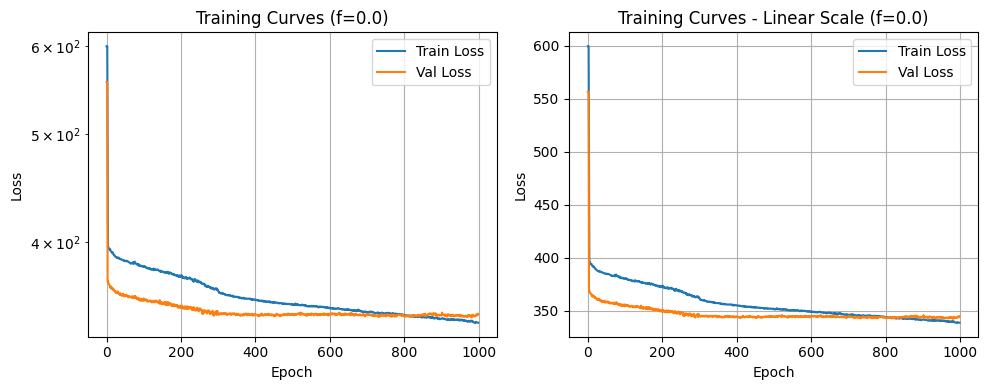

\n=== Results ===
Randomization factor (f): 0.0
Test Accuracy: 22.47%
Model saved as: sgd_shd_norm_f00.pt


In [8]:
# === Train baseline model (f=0) ===
print("=== Training Baseline Model (f=0) ===")

# Prepare dataset
f = 0.0
batch_size = 128
train_loader, val_loader, test_loader = preprocess_dataset(
    X, Y, f=f, batch_size=batch_size, seed=42
)

# Train the model
trained_net = train_model(
    train_loader=train_loader,
    val_loader=val_loader, 
    f=f,
    epochs=1000,
    lr=0.1,
    seed=42
)

# Test the trained model
test_acc = test_accuracy(trained_net, test_loader)
print(f"\\n=== Results ===")
print(f"Randomization factor (f): {f}")
print(f"Test Accuracy: {test_acc:.2%}")

# Save the trained model
model_path = f"sgd_shd_norm_f{int(f*10):02d}.pt"
#model_path = f"sgdelay_shd_norm_f{int(f*10):02d}.pt"
torch.save(trained_net.state_dict(), model_path)
print(f"Model saved as: {model_path}")

Train models with different randomization levels to evaluate temporal robustness. This is optional and can be run separately.

In [ ]:
# === Multi-level robustness evaluation ===
# Uncomment and run this section for comprehensive robustness analysis

"""
f_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

for f in f_values:
    print(f"\\n=== Training Model with f={f} ===")
    
    # Preprocess dataset for this f value
    train_loader, val_loader, test_loader = preprocess_dataset(
        X, Y, f=f, batch_size=128, seed=42
    )
    
    # Train model
    net = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        f=f,
        epochs=1000,
        lr=0.1,
        seed=42
    )
    
    # Test accuracy
    test_acc = test_accuracy(net, test_loader)
    
    # Save model
    model_path = f"slayer_shd_norm_f{int(f*10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    
    # Store results
    results.append({
        'f': f,
        'test_accuracy': test_acc,
        'model_path': model_path
    })
    
    print(f"f={f} | Test Accuracy: {test_acc:.2%} | Saved: {model_path}")

# Print summary
print("\\n=== Robustness Evaluation Summary ===")
for result in results:
    print(f"f={result['f']:.1f}: {result['test_accuracy']:.2%}")
"""

print("Robustness evaluation code is ready.")
print("Uncomment the code above to run multi-level robustness analysis.")